Image segmentation with pytorch? (about 20 minutes for tutorial)

In an image classification task the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case you will want to assign a class to each pixel of the image. This task is known as segmentation. A segmentation model returns much more detailed intofmation about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

## Context

> CamSeq01 is a groundtruth dataset that can be freely used for research work in object recognition in video.


## Content

> This dataset contains 101 960x720 pixel image pairs. Every mask is designated by an "_L" addition to the file name. All images (original and groundtruth) are in uncompressed 24-bit color PNG format.


## Citation

> Julien Fauqueur, Gabriel Brostow, Roberto Cipolla, Assisted Video Object Labeling By Joint Tracking of Regions and Keypoints, IEEE International Conference on Computer Vision (ICCV'2007) Interactive Computer Vision Workshop. Rio de Janeiro, Brazil, October 2007


## Kaggle URL

> https://www.kaggle.com/datasets/carlolepelaars/camseq-semantic-segmentation


> Modified (08/02/2023) from: https://www.kaggle.com/code/erelin6613/sample-deeplabv3-for-segmentation





In [35]:
# download the dataset from kaggle link above or use this script
!pip install -U --no-cache-dir gdown --pre
!gdown 1vxuXLfMnFUYHbuHFZMeBEr-Hvsz6wJ08

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1vxuXLfMnFUYHbuHFZMeBEr-Hvsz6wJ08
To: /content/Camseq_2007.zip
100% 94.6M/94.6M [00:00<00:00, 277MB/s]


In [36]:
# install required libs
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
# check gpu available if not : goto tool-bar -> runtime -> change runtime types -> Hardware accelerator = GPU 
! nvidia-smi

Mon Feb 13 09:00:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    28W /  70W |   7768MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
#  unzip file (-q : quiet mode)
! unzip -q -o ./Camseq_2007.zip 

# Dataset structure for Camseq_2007:
```
contains 204 files = 101 images, 101 label, 1 colormap.txt, 1 readme.txt
Camseq_2007/
  0016E5_07959.png
  0016E5_07959_L.png (label file or called mask)
  ...
  0016E5_08159.png
  0016E5_08159_L.png
  label_colors.txt
  readme.txt

```

In [39]:
# Pytorch framework
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary as summary_info
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

from torch.utils.data import Dataset, DataLoader, random_split, Subset

# utils
import os
import numpy as np
from collections import OrderedDict
from itertools import islice

# Transformation
import albumentations as A
from albumentations.pytorch import ToTensorV2

from collections import OrderedDict

# Visualization
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Progress bar
from tqdm.notebook import tqdm

%matplotlib inline
torch.__version__

'1.13.1+cu116'

## Dataset

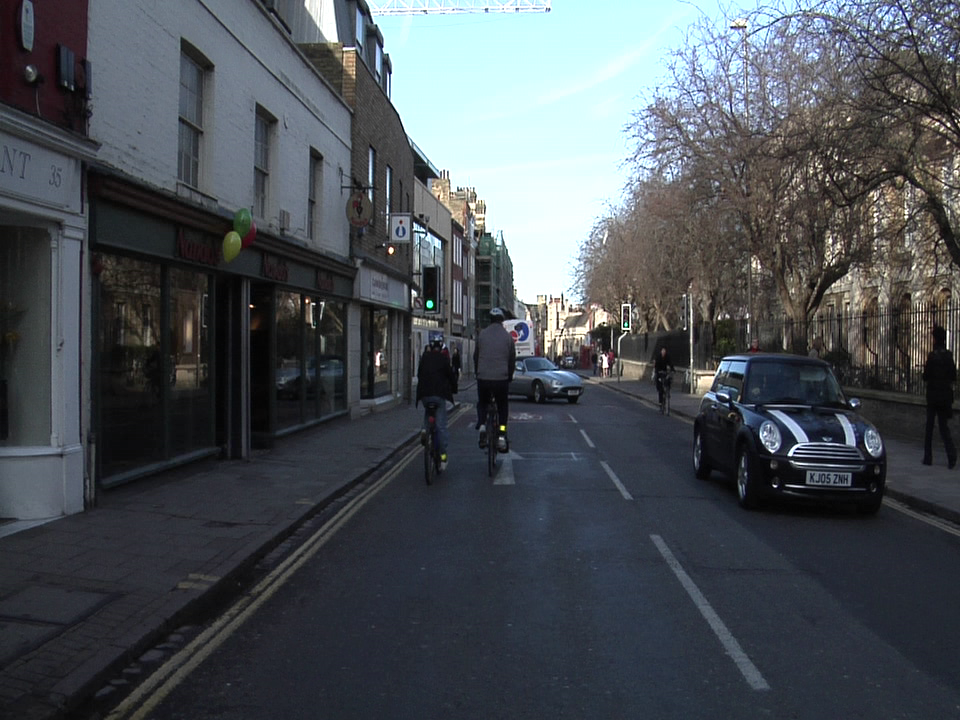

In [40]:
# input image
img = Image.open('./Camseq_2007/0016E5_07961.png')
img

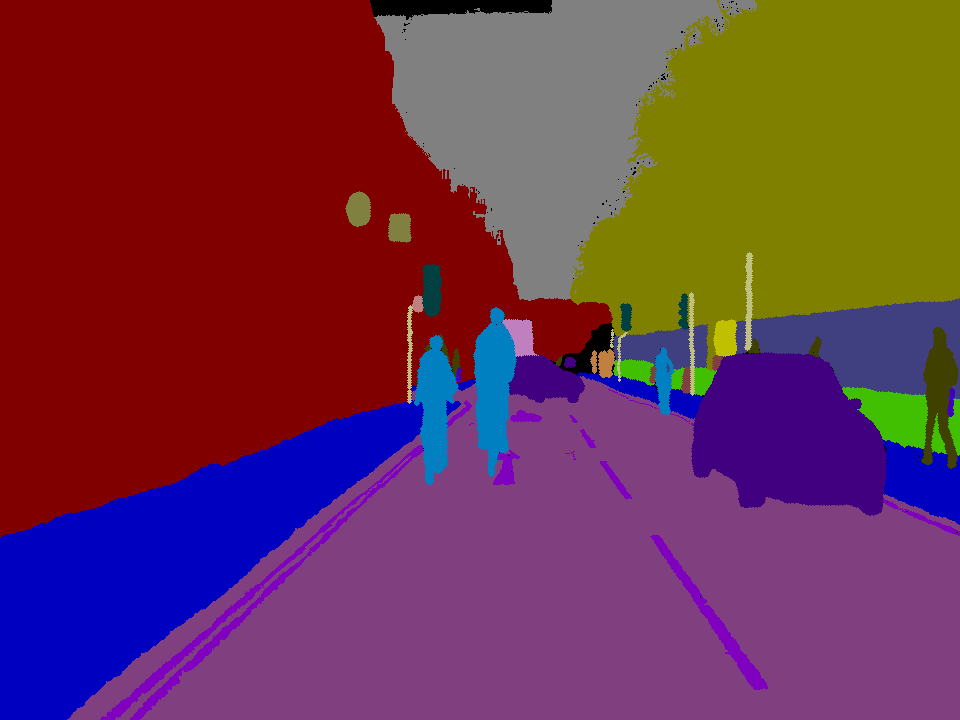

In [41]:
# input mask
img = Image.open('./Camseq_2007/0016E5_07961_L.png')
img

In [42]:
# The mask has only four values but many colors because the colormap is created by combining the four values. (0, 64, 128, 192)
np.unique(np.array(img)[:,:,1])

array([  0,  64, 128, 192], dtype=uint8)

# Colormap example ( [R, G, B] )
```
  'Animal': [64, 128, 64],
  'Archway': [192, 0, 128],
  'Bicyclist': [0, 128, 192],
  'Bridge': [0, 128, 64],
  'Building': [128, 0, 0],
  'Car': [64, 0, 128],
  'CartLuggagePram': [64, 0, 192],
  'Child': [192, 128, 64], 
```

In [43]:
# load colormap from label_colors.txt
colormap = OrderedDict()
with open("./Camseq_2007/label_colors.txt",'r') as f:
    for line in f:
        r,g,b,cls = line.split()  
        colormap[cls] = [int(e) for e in [r,g,b]]
list(islice(colormap.items(),8))

[('Animal', [64, 128, 64]),
 ('Archway', [192, 0, 128]),
 ('Bicyclist', [0, 128, 192]),
 ('Bridge', [0, 128, 64]),
 ('Building', [128, 0, 0]),
 ('Car', [64, 0, 128]),
 ('CartLuggagePram', [64, 0, 192]),
 ('Child', [192, 128, 64])]

In [44]:
class CamSeqDataset(Dataset):
    
    def __init__(self, 
                 img_dir, 
                 colormap=colormap,
                 transforms=None):
        
        super().__init__()
        # sort order of frame from video sequence 
        self.images = sorted([os.path.join(img_dir, e) 
                              for e in os.listdir(img_dir)
                              if not e.split('.')[0].endswith('_L')])
        # remove text files
        self.images = [e for e in self.images if not e.endswith('.txt')]
        self.masks = sorted([os.path.join(img_dir, e) 
                              for e in os.listdir(img_dir)
                              if e.split('.')[0].endswith('_L')])
        self.colormap = colormap
        self.num_classes = len(self.colormap) # 32 classes
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        img = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])
        
        if img.mode != 'RGB':
            img = img.convert('RGB')
        if mask.mode != 'RGB':
            mask = mask.convert('RGB')
            
        img = np.asarray(img) # change from image to array
        mask = np.asarray(mask)
        mask_channels = np.zeros(
            (mask.shape[0], mask.shape[1]), dtype=np.int64)
        
        # convert RGB mask to class-pixel mask ; (R,G,B) -> (Class)
        for i, cls in enumerate(self.colormap.keys()):
            color = self.colormap[cls]
            sub_mask = np.all(mask==color, axis=-1)*i
            mask_channels += sub_mask #*i

        # transforms such as normalization
        if self.transforms is not None:
            transformed = self.transforms(image=img, masks=mask_channels)
            img = transformed['image']
            mask_channels = transformed['masks']
            
        mask_channels = mask_channels.astype(np.float32)
        img = img.astype(np.float32) #/255
        
        instance = {'image': torch.from_numpy(img.transpose(2,0,1)),
                    'mask': torch.from_numpy(mask_channels)}
        
        return instance

    def ___first__(self):
        return self.__getitem__[0]

In [45]:
# simple transform (using ImageNet norm and std) "Albumentation == torchvision.transforms for segmentation"
transform = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
     

In [46]:
dataset = CamSeqDataset(img_dir='./Camseq_2007', colormap=colormap,transforms=transform)
# we split train/val/test -> 70/15/15
train_size = int(len(dataset)*0.7)
val_size = (len(dataset)-train_size)//2
# train_set, rest = random_split(dataset, [train_size, len(dataset)-train_size])
# val_set, test_set = random_split(rest, [val_size, len(rest)-val_size])
# We do not use random split because the dataset is extracted from a video sequence, so nearly every frame looks the same.
train_set = Subset(dataset, range(train_size))
val_set = Subset(dataset, range(train_size, train_size + val_size))
test_set = Subset(dataset, range(train_size + val_size, len(dataset)))


In [47]:
batch_size = 2

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


In [48]:
# loader size : 101 images (train/val/test) -> (70/16/15) -> batch size 2 (35/8/8)
len(train_loader), len(val_loader), len(test_loader)

(35, 8, 8)

## Training

In [49]:
def create_model(out_channels=32):
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    # decoder head
    model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(
        2048, num_classes=out_channels)
    
    model.train()
    return model

In [50]:
def train_model(model, 
                train_loader, 
                val_loader, 
                criterion= nn.CrossEntropyLoss(),
                num_epochs=1,
                device=torch.device('cpu'),
                lr=0.0002,
                model_path="./model.pth"
                ):

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
    metrics = {
          "train_losses" : [],
          "val_losses" : [],
          "train_acc" : [],
          "val_acc" : []
          }
    min_val_loss = 1e10
    for epoch in range(1, num_epochs + 1):
        tr_loss = []
        val_loss = []
        tr_acc = []
        val_acc = []
        model.train()
        print('Epoch {}/{}'.format(epoch, num_epochs))
        for sample in tqdm(train_loader):
            if sample['image'].shape[0]==1:
                break
            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            y_pred = outputs['out']
            y_true = masks
            loss = criterion(y_pred.float(), y_true.long())
            acc = (torch.argmax(y_pred, 1) == y_true).float().mean()
            loss.backward()
            tr_loss.append(loss)
            tr_acc.append(acc)
            optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        avg_tr_loss = torch.mean(torch.Tensor(tr_loss))
        metrics["train_losses"].append(avg_tr_loss)
        avg_tr_acc = torch.mean(torch.Tensor(tr_acc))
        metrics["train_acc"].append(avg_tr_acc)
        print(f'Train loss: {avg_tr_loss}')
        print(f'Train acc: {avg_tr_acc}')

        # Validation phrase
        for sample in tqdm(val_loader):
            if sample['image'].shape[0]==1:
                break
            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
            y_pred = outputs['out']
            y_true = masks
            loss = criterion(y_pred.float(), y_true.long())
            # acc using pixel accuracy. (it is easy to understand,but no way the best metric) 
            # learn more https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
            acc = (torch.argmax(y_pred, 1) == y_true).float().mean()
            val_loss.append(loss)
            val_acc.append(acc)
        avg_val_loss = torch.mean(torch.Tensor(val_loss))
        metrics["val_losses"].append(avg_val_loss)
        avg_val_acc = torch.mean(torch.Tensor(val_acc))
        metrics["val_acc"].append(avg_val_acc)
        print(f'val loss: {avg_val_loss}')
        print(f'val acc: {avg_val_acc}')
        # save model state that have best val loss
        if avg_val_loss < min_val_loss:
            torch.save(model.state_dict(), model_path)
            min_val_loss = avg_val_loss
    return model,metrics

In [51]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
lr =0.0002
print(device)

cuda:0


In [52]:
from torchinfo import summary as summary_info
model = create_model(out_channels=dataset.num_classes)
# model architecture
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [53]:
model.to(device)
# model summary that can pass dummy input to show output shape
# input shape desc : (batch, channel, H, W)
summary_info(model, input_size = (2, 3, 720, 960))

Layer (type:depth-idx)                             Output Shape              Param #
DeepLabV3                                          [2, 21, 720, 960]         --
├─IntermediateLayerGetter: 1-1                     [2, 2048, 90, 120]        --
│    └─Conv2d: 2-1                                 [2, 64, 360, 480]         9,408
│    └─BatchNorm2d: 2-2                            [2, 64, 360, 480]         128
│    └─ReLU: 2-3                                   [2, 64, 360, 480]         --
│    └─MaxPool2d: 2-4                              [2, 64, 180, 240]         --
│    └─Sequential: 2-5                             [2, 256, 180, 240]        --
│    │    └─Bottleneck: 3-1                        [2, 256, 180, 240]        75,008
│    │    └─Bottleneck: 3-2                        [2, 256, 180, 240]        70,400
│    │    └─Bottleneck: 3-3                        [2, 256, 180, 240]        70,400
│    └─Sequential: 2-6                             [2, 512, 90, 120]         --
│    │    └─Bottlen

In [54]:
model = create_model(out_channels=dataset.num_classes)
model,metrics = train_model(model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    num_epochs=6,
                    device=device,
                    lr=lr
                    )

Epoch 1/6


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 0.8910766243934631
Train acc: 0.8625898361206055


  0%|          | 0/8 [00:00<?, ?it/s]

val loss: 0.689324676990509
val acc: 0.8530537486076355
Epoch 2/6


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 0.39940717816352844
Train acc: 0.9183882474899292


  0%|          | 0/8 [00:00<?, ?it/s]

val loss: 0.4795420467853546
val acc: 0.8990723490715027
Epoch 3/6


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 0.2925819754600525
Train acc: 0.9344290494918823


  0%|          | 0/8 [00:00<?, ?it/s]

val loss: 0.46629858016967773
val acc: 0.9120720624923706
Epoch 4/6


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 0.23770272731781006
Train acc: 0.9412471055984497


  0%|          | 0/8 [00:00<?, ?it/s]

val loss: 0.9770591855049133
val acc: 0.7893081307411194
Epoch 5/6


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 0.21352337300777435
Train acc: 0.9423156976699829


  0%|          | 0/8 [00:00<?, ?it/s]

val loss: 0.3835751414299011
val acc: 0.9236634969711304
Epoch 6/6


  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 0.18965327739715576
Train acc: 0.947674572467804


  0%|          | 0/8 [00:00<?, ?it/s]

val loss: 0.37365150451660156
val acc: 0.9202937483787537


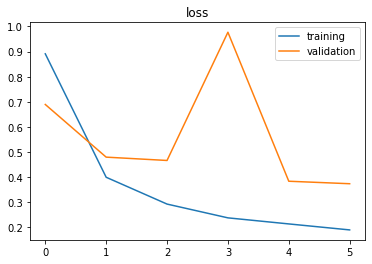

In [55]:
# loss graph
# overfitting because small dataset (only 70 image)
plt.plot(metrics["train_losses"], label = 'training')
plt.plot(metrics["val_losses"], label = 'validation')
plt.title("loss")
plt.legend()

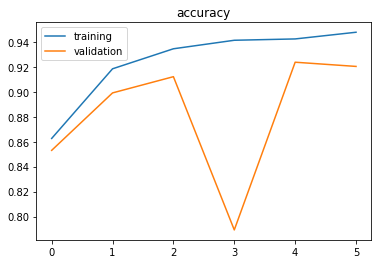

In [56]:
# Pixel accuracy 
plt.plot(metrics["train_acc"], label = 'training')
plt.plot(metrics["val_acc"], label = 'validation')
plt.title("accuracy")
plt.legend()

## Evaluation

In [57]:
# load best val state 
PATH = './model.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [58]:
import gc
with torch.no_grad():
  torch.cuda.empty_cache()
gc.collect()

2582

In [59]:
model.eval()
accuracy = []
with torch.no_grad():
    for sample in tqdm(test_loader):
        if sample['image'].shape[0]==1:
            break
        inputs = sample['image'].to(device)
        masks = sample['mask'].to(device)
        
        outputs = model(inputs)
        y_pred = outputs['out']
        y_true = masks
        # acc using pixel accuracy. (it is easy to understand,but no way the best metric) learn more https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
        acc = (torch.argmax(y_pred, 1) == y_true).float().mean()
        accuracy.append(acc)
accuracy = torch.mean(torch.Tensor(accuracy))
print(f'accuracy: {accuracy}')

  0%|          | 0/8 [00:00<?, ?it/s]

accuracy: 0.903712272644043


## Visualization

In [60]:
model.eval()
img = next(iter(val_loader))   
output = model(img['image'].to(device))['out']

In [61]:
# inverse transform (normalized image -> original)
def invTransform(img):
    img = img*torch.tensor([0.229, 0.224, 0.225]).mean() + torch.tensor([0.485, 0.456, 0.406]).mean()     # unnormalize
    npimg = img.numpy().clip(0,255)
    return npimg

In [62]:
def imshow(img):
    npimg = invTransform(img)
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

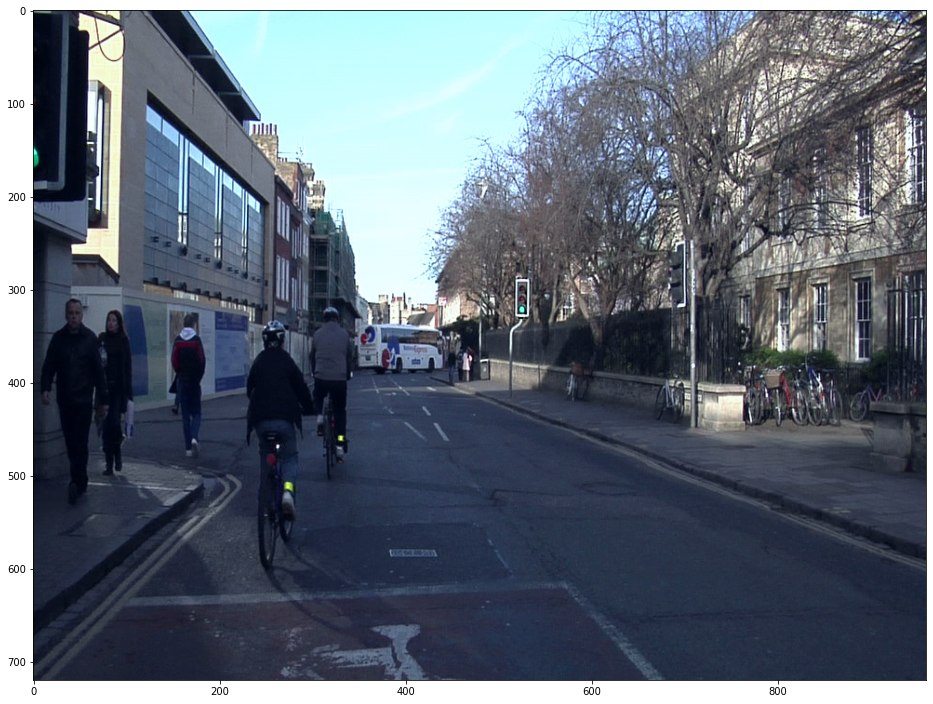

In [63]:
image = img['image'][0]
imshow(image)

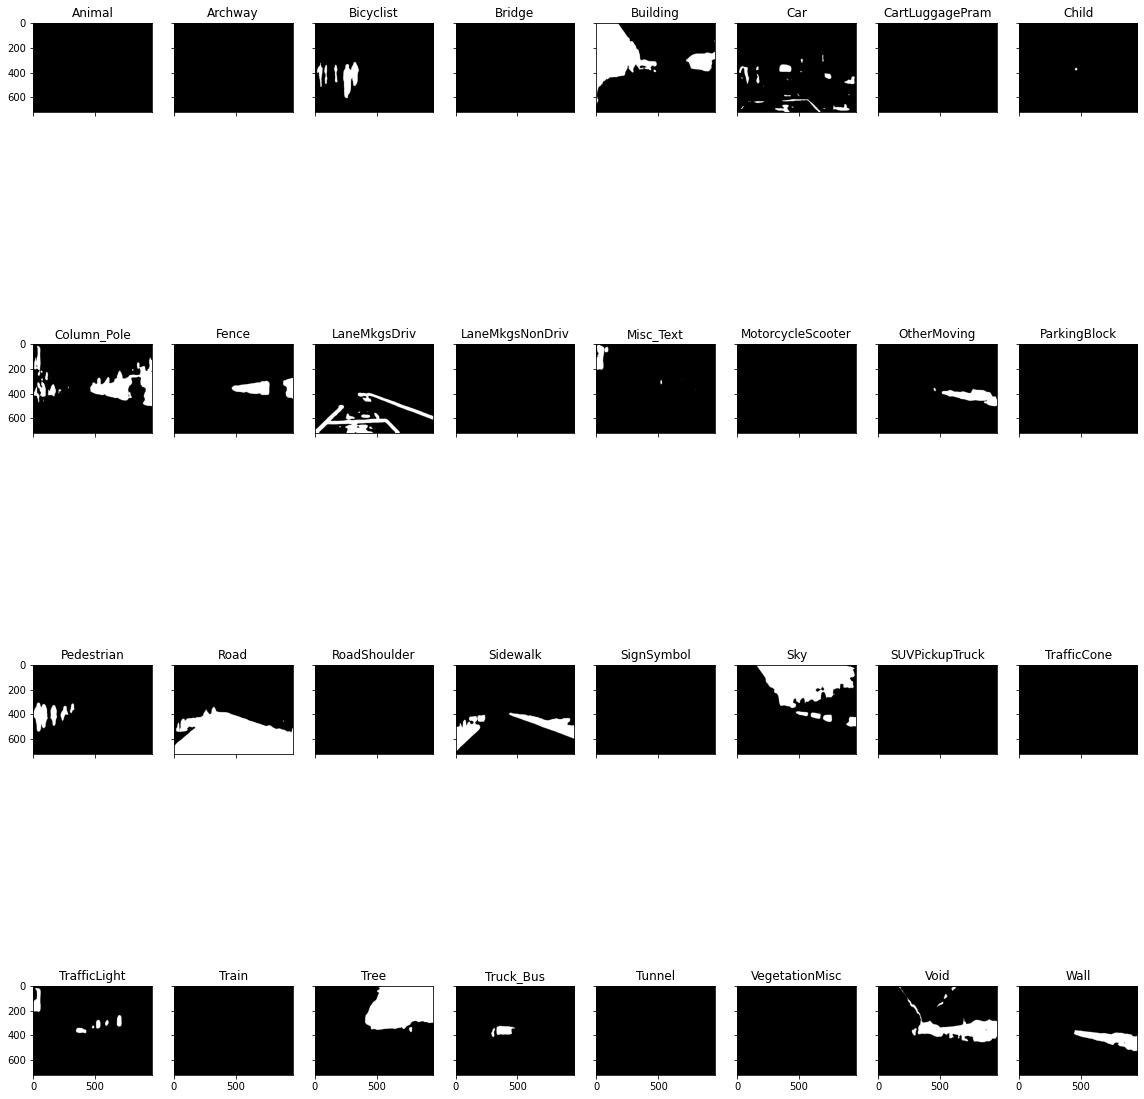

In [64]:
fig, axes = plt.subplots(nrows=4, ncols=8, sharex=True, sharey=True, figsize=(16,20)) 
axes_list = [item for sublist in axes for item in sublist]

thresh=0.3
res = output[0].detach().cpu().numpy()
for i, mask in enumerate(res):
    ax = axes_list.pop(0)
    ax.imshow(np.where(mask>thresh, 255, 0), cmap='gray')
    ax.set_title(list(colormap.keys())[i])

for ax in axes_list: 
    ax.remove()
    
plt.tight_layout()

In [65]:
res.shape

(32, 720, 960)

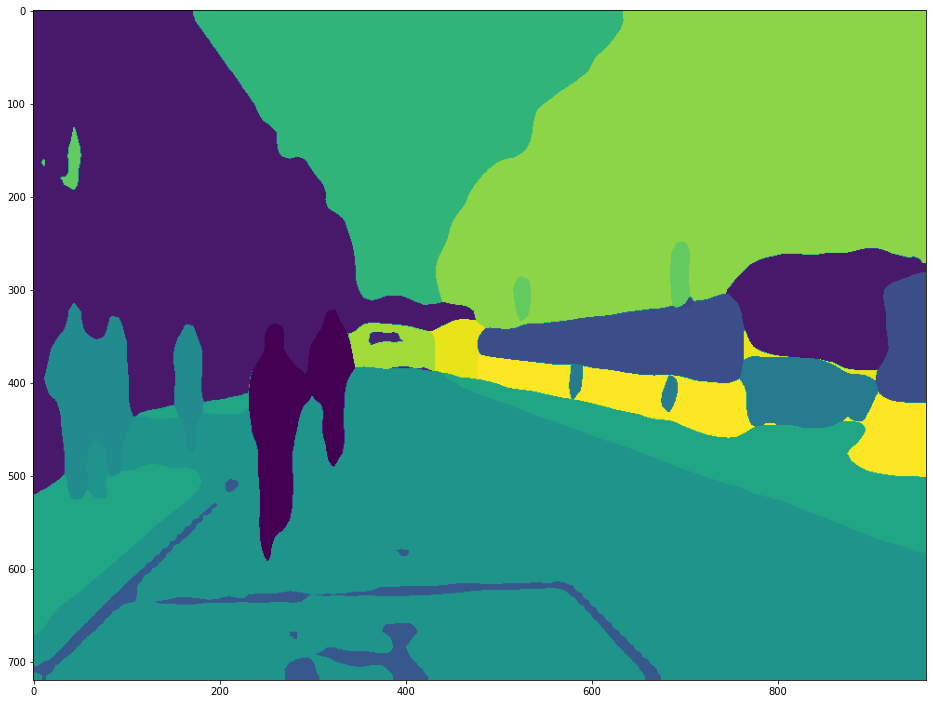

In [66]:
seg = torch.argmax(output[0], 0)
seg = seg.cpu().detach().numpy()
plt.figure(figsize=(16,16))
plt.imshow(seg)  # display image
plt.show()

In [67]:
oiginal_image = invTransform(img['image'][0])
oiginal_image = np.transpose(oiginal_image, (1, 2, 0))

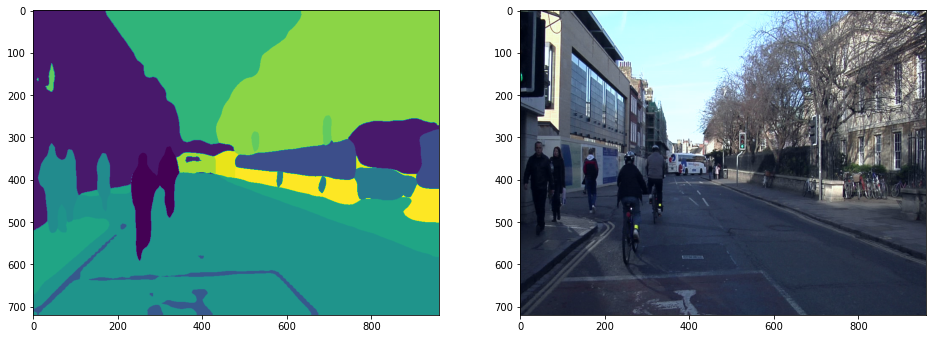

In [68]:
f, axarr = plt.subplots(1,2,figsize= (16,16))
axarr[0].imshow(seg)
axarr[1].imshow(oiginal_image)
plt.show()